In [1]:
# Import to be able to import python package from src
import sys
sys.path.insert(0, '../src')

In [2]:
import ontime as on
import pandas as pd

The `LightGBM` module could not be imported. To enable LightGBM support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md


The `Prophet` module could not be imported. To enable Prophet support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md


# **onTime** — Getting Started

---
## Structure of the Library

The library is divided in three parts : 

1. `core` for all basic features
2. `module` for all features using core features. E.g. benchmarking, ml preprocessing, etc.
3. `context` for all features related to the usage of onTime in an applied scenario

## `core` Features

This is a low level API. Most objects and functions are accessible in the base object : 
    
    ontime
    ├── detectors
    ├── generators
    ├── Model
    ├── plots
    ├── processors
    └── TimeSeries

For instance : 

In [3]:
ts = on.generators.random_walk().generate(start=pd.Timestamp('01-01-2023'), end=pd.Timestamp('12-31-2023'))
ts[0:5]

<TimeSeries (DataArray) (time: 5, component: 1, sample: 1)>
array([[[ 1.00145532]],

       [[-0.44026818]],

       [[ 1.18724831]],

       [[ 1.50822992]],

       [[ 0.98925988]]])
Coordinates:
  * time       (time) datetime64[ns] 2023-01-01 2023-01-02 ... 2023-01-05
  * component  (component) object 'random_walk'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

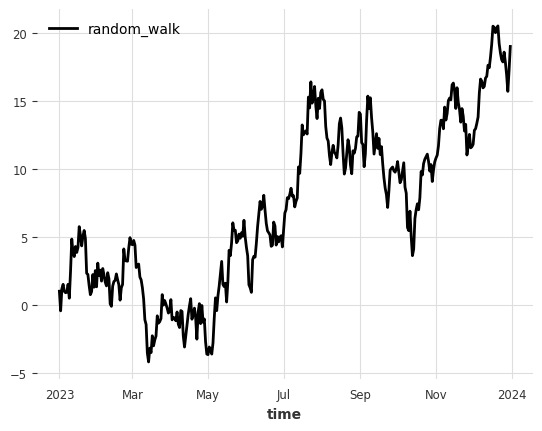

In [4]:
ts.plot();

## `module` and `context` features

High level API with various features. Let's load some data for an example :

In [5]:
from darts.datasets import EnergyDataset
ts = EnergyDataset().load()

In [6]:
df = ts.pd_dataframe()
df = df.interpolate()
cols = ['generation biomass', 'generation solar', 'generation nuclear']
df = df[cols]

In [7]:
ts = on.TimeSeries.from_dataframe(df)

In [8]:
ts_uni = ts['generation solar'].slice(pd.Timestamp('2015'), pd.Timestamp('2016'))
ts_multi = ts.slice(pd.Timestamp('2015'), pd.Timestamp('2016'))

### `module` Features

High level API with features related to data processing, ML/AI, etc.

In [9]:
train, test = on.module.preprocessing.common.train_test_split(ts_uni, test_split=0.3)

### `context` Features

High level API with features related to a physical machine or process.

#### Profiler

In [10]:
profiler = on.context.common.Profiler()

What does the common week looks like ?

In [11]:
week_mean = profiler.profile(ts_uni, profiler.Period.WEEKLY, profiler.Aggregation.MEAN)
week_median = profiler.profile(ts_uni, profiler.Period.WEEKLY, profiler.Aggregation.MEDIAN)

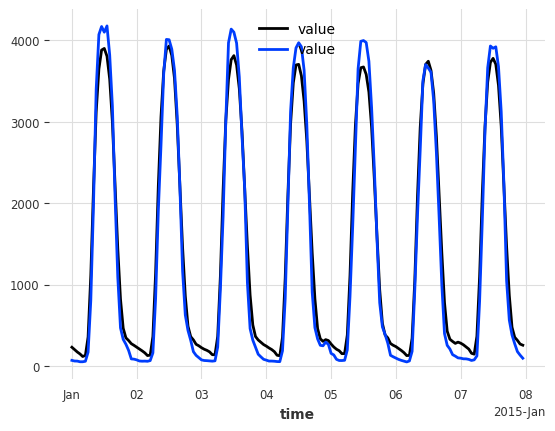

In [12]:
week_mean.plot();
week_median.plot();

#### Generic Predictor

In [13]:
model = on.context.common.GenericPredictor()

In [14]:
model.fit(train)

What does the future looks like ?

In [15]:
pred = model.predict(48)

In [16]:
on.plots.prediction(train[-96:], pred, test[:48])

alt.Chart(...)

## Generic Detector

In [17]:
model = on.context.common.GenericDetector()

In [18]:
model.fit(train)

Does the current signal has problem ? 

In [19]:
detected_test = model.detect(test)

In [20]:
on.plots.anomalies(test[:72], detected_test[:72])

alt.LayerChart(...)

What if we want to have an idea about the future problems ?

In [21]:
predetected = model.predetect(72)

In [22]:
on.plots.anomalies(test[:72], predetected[:72])

alt.LayerChart(...)